In [17]:
# Install required libs
!pip install segmentation-models-pytorch albumentations

In [34]:
!echo "Y" | pip uninstall albumentations

Found existing installation: albumentations 1.3.0
Uninstalling albumentations-1.3.0:
  Would remove:
    /opt/conda/lib/python3.10/site-packages/albumentations-1.3.0.dist-info/*
    /opt/conda/lib/python3.10/site-packages/albumentations/*
Proceed (Y/n)?   Successfully uninstalled albumentations-1.3.0


In [3]:
!echo "Y" | pip uninstall albumentations
!echo "Y" | pip install qudida
!pip install --upgrade albumentations
!pip install --upgrade qudida

  Using cached albumentations-1.3.0-py3-none-any.whl (123 kB)


In [ ]:
#!pip uninstall -y segmentation-models-pytorch

In [3]:
!pip install segmentation-models-pytorch==0.2.0
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 29.1 MB/s eta 0:00:0000:0100:01


In [35]:
!pip install -U albumentations[imgaug]

  Using cached albumentations-1.3.0-py3-none-any.whl (123 kB)


In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [4]:
DATA_DIR = 'vineset'

# load repo with data if it is not exists

In [5]:
x_train_dir = os.path.join(DATA_DIR, 'images', 'train')
y_train_dir = os.path.join(DATA_DIR, 'labels', 'train')

x_valid_dir = os.path.join(DATA_DIR, 'images', 'val')
y_valid_dir = os.path.join(DATA_DIR, 'labels', 'val')

In [6]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [8]:
from tqdm import tqdm
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['trunk']
    
    def __init__(
            self, 
            lstfile, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.images_fps = []
        self.masks_fps = []
        with open(lstfile, 'r') as f:
            trainlist = f.readlines()
            for t in tqdm(trainlist):
                image_path = os.path.join('vineset', t.split('    ')[0].strip())
                label_path = os.path.join('vineset', t.split('    ')[1].strip())
                
                self.images_fps.append(image_path)
                self.masks_fps.append(label_path)
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == 255)]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.images_fps)

In [ ]:
# Lets look at data we have

dataset = Dataset('vineset/train_clean.lst', classes=['trunk'])

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

In [10]:
import albumentations as albu

In [11]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        #albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=128, min_width=128, always_apply=True, border_mode=0),
        albu.RandomCrop(height=128, width=128, always_apply=True),

        albu.transforms.GaussNoise(p=0.2),
        albu.augmentations.Perspective(p=0.5),
        #albu.IAAAdditiveGaussianNoise(p=0.2),
        #albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.augmentations.Sharpen(p=1),
                #albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(128, 128)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
100% 28312/28312 [00:00<00:00, 180215.10it/s]


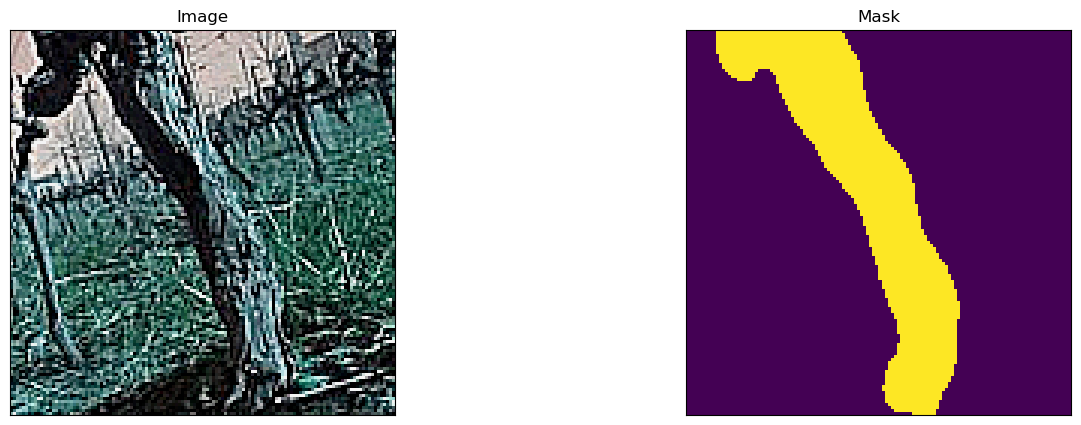

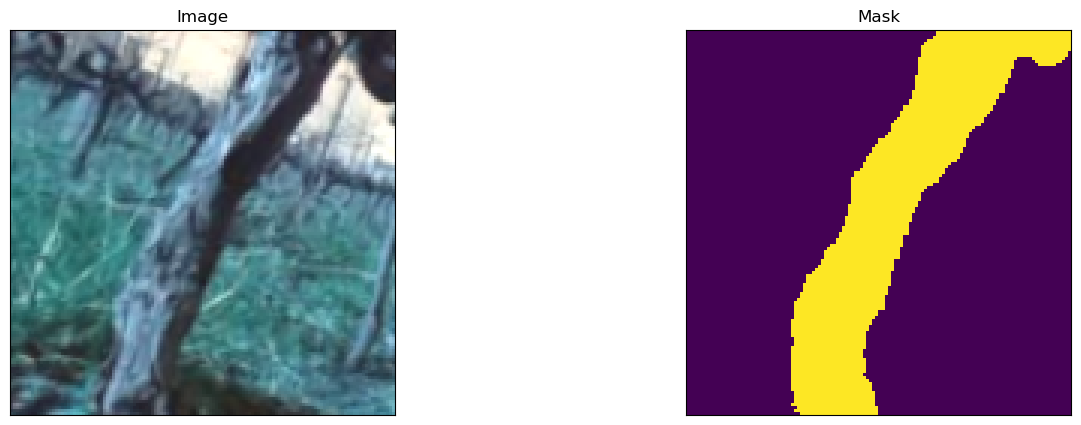

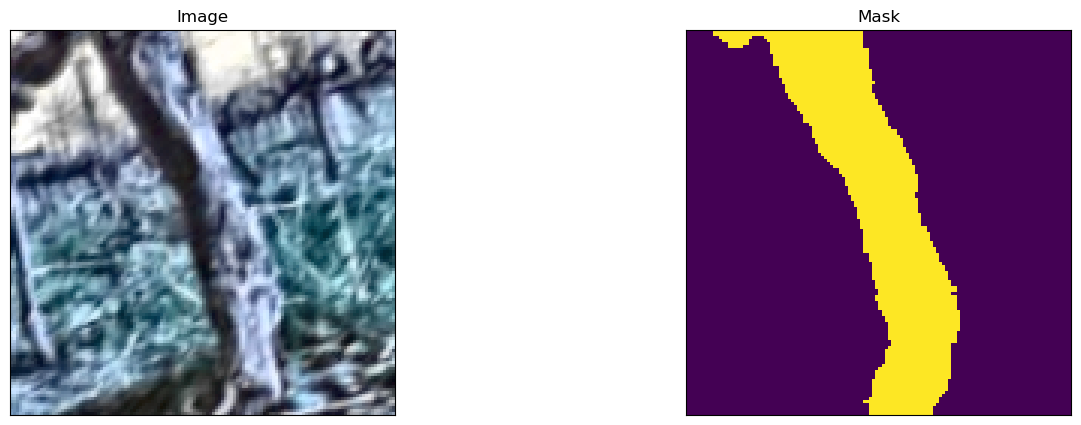

In [12]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    'vineset/train_clean.lst', 
    augmentation=get_training_augmentation(), 
    classes=['trunk'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

## Create model and train

In [13]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [12]:
ENCODER = 'efficientnet-b0'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['trunk']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [13]:
train_dataset = Dataset(
    'vineset/train_clean.lst', 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    'vineset/val_clean.lst',
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

/opt/conda/lib/python3.10/site-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/opt/conda/lib/python3.10/site-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/opt/conda/lib/python3.10/site-packages/alb

In [13]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [14]:
import wandb
wandb.login()
run = wandb.init(project='SM models')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hellvetica. Use `wandb login --relogin` to force relogin


In [ ]:
# train model for 40 epochs

max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    config = {}
    for k, v in train_logs.items():
        config['train_'+k] = v
    for k, v in valid_logs.items():
        config['valid_'+k] = v
    
    wandb.log(config)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train: 100% 3539/3539 [06:51<00:00,  8.59it/s, dice_loss - 0.1321, iou_score - 0.7775]
valid: 100% 7085/7085 [03:28<00:00, 34.04it/s, dice_loss - 0.1139, iou_score - 0.8099]
Model saved!

Epoch: 1
train: 100% 3539/3539 [06:48<00:00,  8.66it/s, dice_loss - 0.1078, iou_score - 0.8099]
valid: 100% 7085/7085 [03:30<00:00, 33.62it/s, dice_loss - 0.1058, iou_score - 0.8201]
Model saved!

Epoch: 2
train: 100% 3539/3539 [06:48<00:00,  8.66it/s, dice_loss - 0.1031, iou_score - 0.8166]
valid: 100% 7085/7085 [03:31<00:00, 33.49it/s, dice_loss - 0.1025, iou_score - 0.8246] 
Model saved!

Epoch: 3
train: 100% 3539/3539 [06:46<00:00,  8.71it/s, dice_loss - 0.1007, iou_score - 0.8201]
valid: 100% 7085/7085 [03:33<00:00, 33.23it/s, dice_loss - 0.1023, iou_score - 0.824]  

Epoch: 4
train: 100% 3539/3539 [06:50<00:00,  8.62it/s, dice_loss - 0.09792, iou_score - 0.8243]
valid: 100% 7085/7085 [03:34<00:00, 32.98it/s, dice_loss - 0.09876, iou_score - 0.83]  
Model saved!

Epoch: 5
train: 100% 35

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



valid:  72% 5108/7085 [02:42<01:03, 31.20it/s, dice_loss - 0.09096, iou_score - 0.841] 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



train: 100% 3539/3539 [07:03<00:00,  8.35it/s, dice_loss - 0.08548, iou_score - 0.8437]
valid: 100% 7085/7085 [03:41<00:00, 32.02it/s, dice_loss - 0.09197, iou_score - 0.8394]

Epoch: 24
train: 100% 3539/3539 [07:02<00:00,  8.38it/s, dice_loss - 0.08486, iou_score - 0.8448]
valid: 100% 7085/7085 [03:41<00:00, 32.00it/s, dice_loss - 0.09121, iou_score - 0.8406]
Model saved!

Epoch: 25
train:  81% 2876/3539 [05:47<01:20,  8.21it/s, dice_loss - 0.08473, iou_score - 0.8449]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



train: 100% 3539/3539 [07:06<00:00,  8.30it/s, dice_loss - 0.08296, iou_score - 0.8479]
valid: 100% 7085/7085 [03:38<00:00, 32.38it/s, dice_loss - 0.09025, iou_score - 0.8424]
Model saved!

Epoch: 27
train: 100% 3539/3539 [07:06<00:00,  8.30it/s, dice_loss - 0.08233, iou_score - 0.849] 
valid: 100% 7085/7085 [03:40<00:00, 32.19it/s, dice_loss - 0.09001, iou_score - 0.8428]
Model saved!

Epoch: 28
train: 100% 3539/3539 [07:09<00:00,  8.24it/s, dice_loss - 0.0818, iou_score - 0.8499] 
valid: 100% 7085/7085 [03:38<00:00, 32.37it/s, dice_loss - 0.09012, iou_score - 0.8426]

Epoch: 30
train:  78% 2759/3539 [05:32<01:32,  8.39it/s, dice_loss - 0.0816, iou_score - 0.8503] 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



train: 100% 3539/3539 [07:04<00:00,  8.34it/s, dice_loss - 0.08131, iou_score - 0.8507]
valid: 100% 7085/7085 [03:40<00:00, 32.10it/s, dice_loss - 0.09007, iou_score - 0.8427]

Epoch: 32
valid: 100% 7085/7085 [03:40<00:00, 32.07it/s, dice_loss - 0.08994, iou_score - 0.8429]
Model saved!

Epoch: 33
train: 100% 3539/3539 [07:04<00:00,  8.34it/s, dice_loss - 0.08128, iou_score - 0.8508]
train: 100% 3539/3539 [07:04<00:00,  8.33it/s, dice_loss - 0.08097, iou_score - 0.8513]
train: 100% 3539/3539 [07:05<00:00,  8.33it/s, dice_loss - 0.08074, iou_score - 0.8516]
valid: 100% 7085/7085 [03:40<00:00, 32.16it/s, dice_loss - 0.08982, iou_score - 0.8431]

Epoch: 37
valid: 100% 7085/7085 [03:41<00:00, 31.99it/s, dice_loss - 0.08976, iou_score - 0.8432]

Epoch: 38
valid: 100% 7085/7085 [03:40<00:00, 32.11it/s, dice_loss - 0.08982, iou_score - 0.8431]

Epoch: 39
train: 100% 3539/3539 [07:07<00:00,  8.27it/s, dice_loss - 0.08045, iou_score - 0.8522]
valid:  58% 4125/7085 [02:09<01:33, 31.72it/s, dice_

In [51]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.1 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.7 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=f7e13572368d066cdbf019b681c3807625c640e50f339a83710a4835b927c758
  Stored in directory: /home/jovyan/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [1]:
import wandb

In [2]:
wandb_api = "api_key"
wandb.login(key=wandb_api)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jovyan/.netrc


True

In [ ]:

import segmentation_models_pytorch.utils.metrics


def getUPP():
    return smp.UnetPlusPlus

def getDLV3():
    return smp.DeepLabV3Plus
def getPAN():
    return smp.PAN
def getPSP():
    return smp.PSPNet
def getMANET():
    return smp.MAnet
def getLink():
    return smp.Linknet
configs = [
    {'modelname':'UnetPlusPlus', 'getModel':getUPP},
    {'modelname':'DeepLabV3Plus', 'getModel':getDLV3},
    {'modelname':'PAN', 'getModel':getPAN},
    {'modelname':'PSP', 'getModel':getPSP},
    {'modelname':'MANET', 'getModel':getMANET},
    {'modelname':'Link', 'getModel':getLink},
]

for c in configs:
    #ENCODER = 'timm-mobilenetv3_large_075'
    #ENCODER = 'efficientnet-b0'
    ENCODER = 'mobilenet_v2'
    ENCODER_WEIGHTS = 'imagenet'
    CLASSES = ['trunk']
    ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
    DEVICE = 'cuda'

    # create segmentation model with pretrained encoder
    model = c['getModel']()(
        encoder_name=ENCODER, 
        encoder_weights=ENCODER_WEIGHTS, 
        classes=len(CLASSES), 
        activation=ACTIVATION,
    )

    preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
    
    train_dataset = Dataset(
        'vineset/train_clean.lst', 
        augmentation=get_training_augmentation(), 
        preprocessing=get_preprocessing(preprocessing_fn),
        classes=CLASSES,
    )

    valid_dataset = Dataset(
        'vineset/val_clean.lst',
        augmentation=get_validation_augmentation(), 
        preprocessing=get_preprocessing(preprocessing_fn),
        classes=CLASSES,
    )

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=12)
    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)
    
    loss = smp.utils.losses.DiceLoss()
    metrics = [
        smp.utils.metrics.IoU(threshold=0.5),
    ]

    optimizer = torch.optim.Adam([ 
        dict(params=model.parameters(), lr=0.0001),
    ])
    
    # create epoch runners 
    # it is a simple loop of iterating over dataloader`s samples
    train_epoch = smp.utils.train.TrainEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        optimizer=optimizer,
        device=DEVICE,
        verbose=True,
    )

    valid_epoch = smp.utils.train.ValidEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        device=DEVICE,
        verbose=True,
    )
    import wandb
    wandb.login()
    run = wandb.init(project='SM models', name=f"{c['modelname']}_{ENCODER}_CLEAN")
    max_score = 0

    for i in range(0, 40):

        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)

        config = {}
        for k, v in train_logs.items():
            config['train_'+k] = v
        for k, v in valid_logs.items():
            config['valid_'+k] = v

        wandb.log(config)

        # do something (save model, change lr, etc.)
        if max_score < valid_logs['iou_score']:
            max_score = valid_logs['iou_score']
            torch.save(model, f"./best_model_{c['modelname']}_{ENCODER}.pth")
            print('Model saved!')

        if i == 25:
            optimizer.param_groups[0]['lr'] = 1e-5
            print('Decrease decoder learning rate to 1e-5!')

In [ ]:
wandb.finish()

## Test best saved model

In [20]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [21]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [22]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 233/233 [00:08<00:00, 27.19it/s, dice_loss - 0.1979, iou_score - 0.7498]


## Visualize predictions

In [19]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    'vineset/val.lst', 
    classes=CLASSES,
)

100% 7583/7583 [00:00<00:00, 171265.68it/s]


In [ ]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )